## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mgimg
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import os
import datetime
import folium
import math
from matplotlib import animation
from IPython.display import Image, display
from sklearn.cluster import KMeans

## Plot

#### WHAT IS COVID-19

Coronavirus disease (**COVID-19**) is an infectious disease caused by the SARS-CoV-2 virus.

Most people who fall sick with COVID-19 will experience mild to moderate symptoms and recover without special treatment. However, some will become seriously ill and require medical attention or even deceased.

#### HOW IT SPREADS

The virus can spread from an infected person’s mouth or nose in small liquid particles when they cough, sneeze, speak, sing or breathe. These particles range from larger respiratory droplets to smaller aerosols.
You can be infected by breathing in the virus if you are near someone who has COVID-19, or by touching a contaminated surface and then your eyes, nose or mouth. The virus spreads more easily indoors and in crowded settings.

#### OBJECTIVE

South Korea is a highly developed country. The aim of this project is to analyse patient-level data from South Korea's COVID-19 and prepare your home country for the next pandemic wave, to develop and demonstrate a plan to combat a pandemic in your country by analysing the data provided.

## Dataset

Dataset consist of **11** separate files. It holds various data like cases, locations, epidemiological data, wheather etc for period of **2020-01-20 - 2020-06-30**, in other words from the very start of Covid-19 spread till it gained full speed. With a help of this data we'll try to draw a picture of causes of the spread.

At the time of this data collection vaccination of the population had not yet started, thus the impact on spread and fight against virus is a subject of another analysis.

In [2]:
path = './data/'

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/Case.csv
./data/PatientInfo.csv
./data/Policy.csv
./data/Region.csv
./data/SearchTrend.csv
./data/SeoulFloating.csv
./data/Time.csv
./data/TimeAge.csv
./data/TimeGender.csv
./data/TimeProvince.csv
./data/Weather.csv


### Data Checking & Cleaning

#### CASE

In [3]:
filename = "./data/Case.csv"

df_Case = pd.read_csv(filename, encoding='utf-8')
df_Case.head()

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,139,37.538621,126.992652
1,1000002,Seoul,Gwanak-gu,True,Richway,119,37.48208,126.901384
2,1000003,Seoul,Guro-gu,True,Guro-gu Call Center,95,37.508163,126.884387
3,1000004,Seoul,Yangcheon-gu,True,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,1000005,Seoul,Dobong-gu,True,Day Care Center,43,37.679422,127.044374


Data of COVID-19 infection cases in South Korea:

* `case_id` : the ID of the infection case.
* `province` : Special City / Metropolitan City / Province(-do).
* `city` : City(-si) / Country (-gun) / District (-gu).
* `group` : TRUE: group infection / FALSE: not group.
* `infection_case` : the infection case (the name of group or other cases).
* `confirmed` : the accumulated number of the confirmed.
* `latitude` : the latitude of the group (WGS84).
* `longitude` : the longitude of the group (WGS84).

In [4]:
df_Case.rename(columns={' case_id': 'case_id'}, inplace=True)

#### TIME

In [5]:
filename = "./data/Time.csv"

df_Time = pd.read_csv(filename, encoding='utf-8')
df_Time.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


Time series data of COVID-19 status in South Korea
* `date`: YYYY-MM-DD
* `time`: Time (0 = AM 12:00 / 16 = PM 04:00)
* `test`: the accumulated number of tests
* `negative`: the accumulated number of negative results
* `confirmed`: the accumulated number of positive results
* `released`: the accumulated number of releases
* `deceased`: the accumulated number of deceases

The columns `test`, `negative`, `confirmed`, `released`, `deceased` are the accumulated numbers. Let's calculate the day values.

In [6]:
df_Time_columns = ['test', 'negative', 'confirmed', 'released', 'deceased']
for column in df_Time_columns:
    df_Time[f'{column}_per_day'] = df_Time[column] - df_Time[column].shift(1)
    df_Time.loc[:0, f'{column}_per_day'] = df_Time[column][0]

df_Time["date"] = pd.to_datetime(df_Time["date"])

In [7]:
df_Time['date'] = pd.to_datetime(df_Time['date'])

In [8]:
df_Time.head()

,date,time,test,negative,confirmed,released,deceased,test_per_day,negative_per_day,confirmed_per_day,released_per_day,deceased_per_day
0,2020-01-20,16,1,0,1,0,0,1.0,0.0,1.0,0.0,0.0
1,2020-01-21,16,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0
2,2020-01-22,16,4,3,1,0,0,3.0,3.0,0.0,0.0,0.0
3,2020-01-23,16,22,21,1,0,0,18.0,18.0,0.0,0.0,0.0
4,2020-01-24,16,27,25,2,0,0,5.0,4.0,1.0,0.0,0.0


#### POLICY

In [9]:
filename = "./data/Policy.csv"

df_Policy = pd.read_csv(filename, encoding='utf-8')
df_Policy.head()

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN


Data of the government policy for COVID-19 in South Korea.

* `policy_id`: the ID of the policy
* `country`: the country that implemented the policy
* `type`: the type of the policy
* `gov_policy`: the policy of the government
* `detail`: the detail of the policy
* `start_date`: the start date of the policy
* `end_date`: the end date of the policy

In [10]:
# Some of the column `detail` fields has null value. I will fill it with empty string instead.
df_Policy['detail'] = df_Policy['detail'].fillna('')

# There are duplicating entries of policies with very slightly different date of entry into force.
# Since I'd like to show it in graph and all policies will not fit to be readable, I will drop some of them
# by leaving one for reference.
df_Policy.drop(df_Policy.index[[0, 7, 8, 9, 10, 11, 12, 13, 14,
               15, 16, 19, 20, 21, 22, 23, 24, 58, 49, 60, 56]], inplace=True)

# Some namings are very very long, or detail dupllicates policy naming.
# We'll need to rename it for clearance and to fit a graph later.
df_Policy.loc[24:24, 'detail'] = ''
df_Policy.loc[25:25, 'detail'] = ''
df_Policy.loc[52:52, 'detail'] = 'who violate self-quarantine'
df_Policy.loc[53:53, 'detail'] = ''
df_Policy.loc[54:54, 'detail'] = 'Limited gathering for vulnerable groups'
df_Policy.loc[54:54, 'gov_policy'] = 'Admin. orders'
df_Policy.loc[59:59, 'detail'] = 'QR code system in entertain. facilities'
df_Policy.loc[59:59, 'gov_policy'] = 'Kl-pass'
df_Policy.loc[55:55, 'detail'] = '2 weeks ban'
df_Policy.loc[57:57, 'detail'] = 'Mandatory wearing at airports'
# Let's convert the date fields to datetime.
df_Policy[["start_date", "end_date"]] = df_Policy[[
    "start_date", "end_date"]].apply(pd.to_datetime)

Let's group the policies by their date comming into force. As description of the policy we'll concatenate the `gov_policy` and `detail` fields. We'll assign a value to 1 for the policies to be on the same level at the graph.

In [11]:
policy_by_time = pd.DataFrame(df_Policy.groupby(
    ['start_date'], as_index=False).agg({'gov_policy': 'first', 'detail': 'first'}))

policy_by_time["policy"] = (
    policy_by_time["gov_policy"]
    + ' '
    + policy_by_time["detail"])

policy_by_time.drop(['gov_policy', 'detail'], axis=1, inplace=True)
policy_by_time["value"] = 1

#### PATIENT INFO

In [12]:
filename = "./data/PatientInfo.csv"

df_Patient_info = pd.read_csv(filename, encoding='utf-8', index_col=0)

df_Patient_info.head()

,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
patient_id,,,,,,,,,,,,,
1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


Epidemiological data of COVID-19 patients in South Korea
* `patient_id`: the ID of the patient
* `sex`: the sex of the patient
* `age`: the age of the patient 0s: 0 ~ 9 10s: 10 ~ 19 etc.
* `country`: the country of the patient
* `province`: the province of the patient
* `city`: the city of the patient
* `infection_case`: the case of infection
* `infected_by`: the ID of who infected the patient
* `contact_number`: the number of contacts with people
* `symptom_onset_date`: the date of symptom onset
* `confirmed_date`: the date of being confirmed
* `released_date`: the date of being released
* `deceased_date`: the date of being deceased
* `state`: isolated / released / decease`

In [13]:
df_Patient_info["confirmed_date"] = pd.to_datetime(
    df_Patient_info["confirmed_date"])
df_Patient_info["released_date"] = pd.to_datetime(
    df_Patient_info["released_date"])
df_Patient_info["deceased_date"] = pd.to_datetime(
    df_Patient_info["deceased_date"])

In [14]:
df_Patient_info['contact_number'].unique()

array(['75', '31', '17', '9', '2', '43', '0', '68', '6', '23', '117',
       '27', '8', nan, '4', '3', '1', '1000000796', '13', '12', '1091',
       '131', '16', '14', '485', '19', '296', '15', '34', '37', '22', '7',
       '10', '28', '21', '5', '25', '18', '159', '11', '30', '41', '71',
       '38', '24', '185', '69', '39', '1160', '450', '65', '156', '47',
       '86', '74', '46', '64', '66', '40', '20', '42', '107', '29', '26',
       '45', '-', '95', '422', '290', '32', '53', '70', '35', '51', '130',
       '106', '174', '78', '33', '89', '61', '113', '36', '6100000098',
       '6100000099', '87', '84', '140', '72'], dtype=object)

We see that column `contact_number` type is an object. Beside the numbers it has values such as "nan", "-", and as well some improper values were `infected_by` number is shown. Let's fix this by assigning **0** to non existing values.

In [15]:
df_Patient_info["contact_number"] = df_Patient_info["contact_number"].fillna(0)
df_Patient_info["contact_number"] = df_Patient_info["contact_number"].replace("-", 0)
df_Patient_info["contact_number"] = df_Patient_info["contact_number"].astype("int64")

df_Patient_info["contact_number"].sort_values(ascending=False).head()

patient_id
6100000098    6100000099
6100000097    6100000098
1000000819    1000000796
1200000031          1160
1100000001          1091
Name: contact_number, dtype: int64

In [16]:
df_Patient_info.at[1000000819, "infected_by"] = 1000000796
df_Patient_info.at[6100000097, "infected_by"] = 6100000098
df_Patient_info.at[6100000098, "infected_by"] = 6100000099
df_Patient_info.at[1000000819, "contact_number"] = 0
df_Patient_info.at[6100000097, "contact_number"] = 0
df_Patient_info.at[6100000098, "contact_number"] = 0

#### TIME GENDER

In [17]:
filename = "./data/TimeGender.csv"

df_TimeGender = pd.read_csv(filename, encoding='utf-8')
df_TimeGender.head()

,date,time,sex,confirmed,deceased
0,2020-03-02,0,male,1591,13
1,2020-03-02,0,female,2621,9
2,2020-03-03,0,male,1810,16
3,2020-03-03,0,female,3002,12
4,2020-03-04,0,male,1996,20


Time series data of COVID-19 status in terms of the gender in South Korea
* `date`: YYYY-MM-DD
* `time`: Time
* `sex`: the gender of patients
* `confirmed`: the accumulated number of the confirmed
* `deceased`: the accumulated number of the deceased

#### TIME AGE

In [18]:
filename = "./data/TimeAge.csv"

df_TimeAge = pd.read_csv(filename, encoding='utf-8')
df_TimeAge.head()

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1


Time series data of COVID-19 status in terms of the age in South Korea
* `date`: YYYY-MM-DD
* `time`: Time
* `age`: the age of patients
* `confirmed`: the accumulated number of the confirmed
* `deceased`: the accumulated number of the deceased

### EDA of epidemiological data of COVID-19 patients in South Korea

In [19]:
path = './map_density/PNG/'
fig = plt.figure(figsize=(12, 14))
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

yellow_patch = mpatches.Patch(color='#FCEED3', label='Confirmed 1~9')
ligth_orange_patch = mpatches.Patch(color='#F2A88D', label='Confirmed 10~99')
orange_patch = mpatches.Patch(color='#E36654', label='Confirmed 100~499')
red_patch = mpatches.Patch(color='#E5354B', label='Confirmed 500~999')
brown_patch = mpatches.Patch(color='#87353F', label='Confirmed 1000~9999')

plt.legend(handles=[yellow_patch, ligth_orange_patch, orange_patch,
                    red_patch, brown_patch],
           loc='best',
           fontsize=14,
           framealpha=0.5,
           markerfirst=False)

myimages = []

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        img = mgimg.imread(os.path.join(dirname, filename))
        imgplot = plt.imshow(img)
        t = plt.text(
            0,
            -10,
            str(f"{filename[:4]}-{filename[4:6]}-{filename[6:8]}"),
            fontsize=26)
        myimages.append([imgplot, t])

my_anim = animation.ArtistAnimation(fig, myimages, interval=350)
my_anim.save('output_density.gif', writer='pillow')

plt.close()

Animated timeline of a map of special cities & municipals of South Korea with confirmed or suspected coronavirus cases (2020-02-26 - 2020-06-30)<sup>1</sup>.

1. [Source: COVID-19 Outbreak Cases in South Korea (Density)](https://commons.wikimedia.org/wiki/File:COVID-19_Outbreak_Cases_in_South_Korea_(Density).svg)

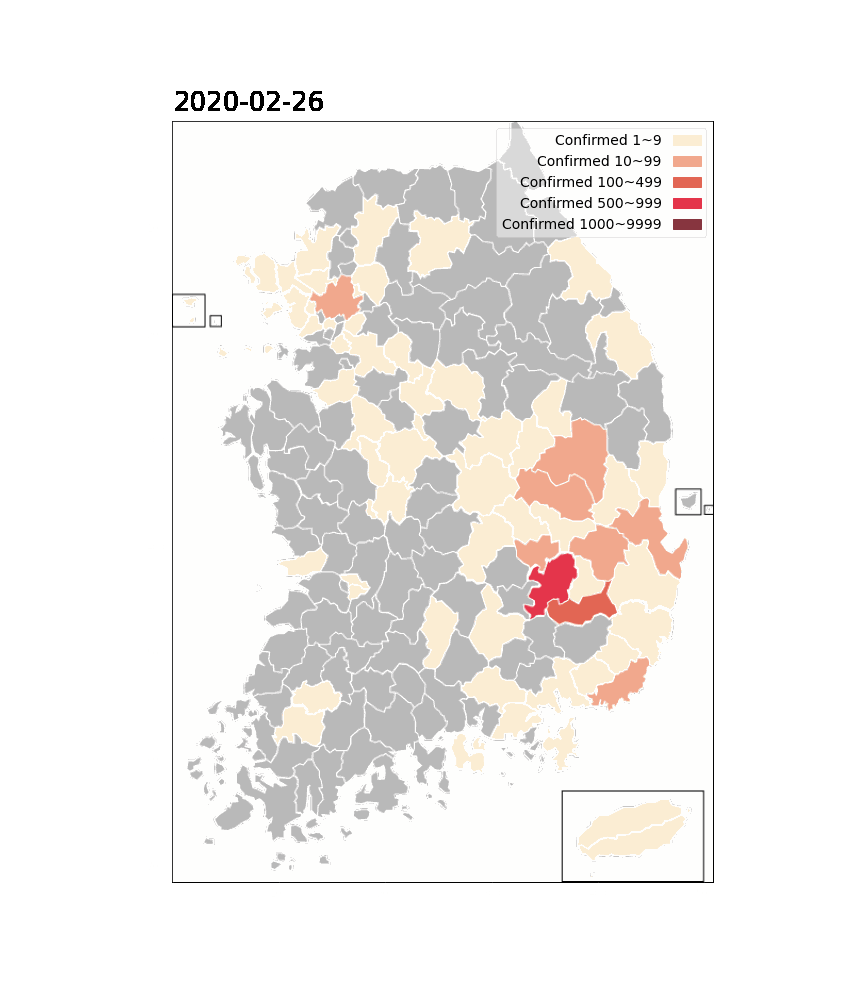

In [20]:
with open('./output_density.gif', 'rb') as f:
    display(Image(data=f.read()))

Let's see our Case data for more details

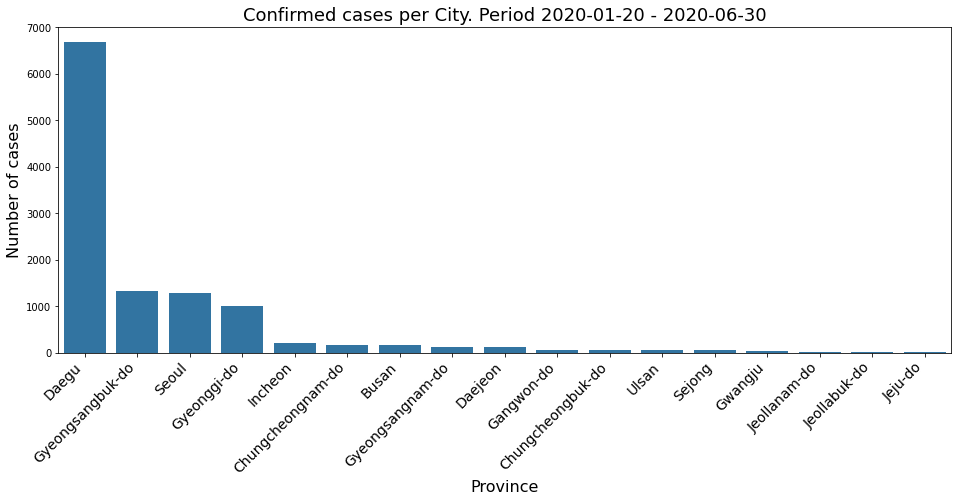

In [21]:
plt.figure(figsize=(16, 6))

confirmed_cases = pd.DataFrame(df_Case.groupby(["province"])["confirmed"].agg('sum'))
confirmed_cases = confirmed_cases.sort_values(by=["confirmed"], ascending=False)
confirmed_cases = confirmed_cases.reset_index()

ax = sns.barplot(
    x=confirmed_cases['province'],
    y=confirmed_cases["confirmed"],
    color="#1F77B4")

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=14)

ax.set_title("Confirmed cases per City. Period 2020-01-20 - 2020-06-30", fontsize=18)
ax.set_xlabel("Province", fontsize=16)
ax.set_ylabel("Number of cases", fontsize=16)

plt.show()

Let's try to clusterize the locations of cases. First, we'll check optimal number of clusters using Elbow Curve analysis.

In [22]:
df_Case_map = df_Case.copy()

# There is one row that has string '-'instead of coordinates.
# Let's filter it out and change column type to float

for col_name in ['longitude', 'latitude']:
    df_Case_map = df_Case_map[df_Case_map[col_name] != '-']
    df_Case_map[col_name] = df_Case_map[col_name].astype('float64')

df = df_Case_map.loc[:, ['case_id', 'longitude', 'latitude']]

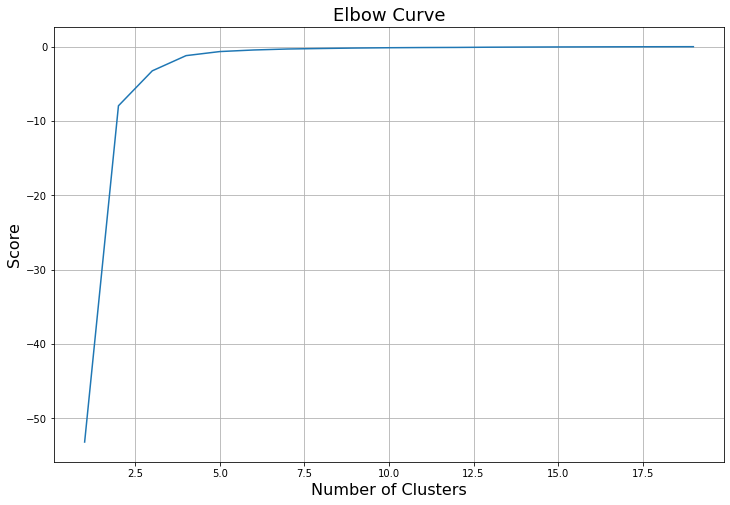

In [23]:
K_clusters = range(1,20)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

X_axis, Y_axis = df[['longitude']], df[['latitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

plt.figure(figsize=(12, 8))
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.title('Elbow Curve', fontsize=18)
plt.grid()
plt.show()

We'll do the clustering using K-means algorithm. I'll try to run with 4 clusters and results we'll show on the map.

In [24]:
kmeans = KMeans(n_clusters=4, init ='k-means++')
kmeans.fit(df[df.columns[0:2]])

df['cluster_label'] = kmeans.fit_predict(df[df.columns[1:3]])
centroids = kmeans.cluster_centers_

colors = {0:'red', 1:'green', 2:'orange', 3:'black'}
scale_factor = 0.45
route_map = folium.Map(
    location=[36.5, 128],
    min_zoom=3,
    max_zoom=10,
    zoom_start=7,
    tiles="cartodbpositron")

for lat, lon, cluster in zip(df["latitude"],
                           df["longitude"], df['cluster_label']):
        folium.CircleMarker(
            [lat, lon],
            color=colors[cluster],
            radius=2,
            fill=True,
            fill_color="crimson",
            fill_opacity=0.4).add_to(route_map)

for j, (lat, lon) in enumerate(centroids):
    folium.CircleMarker(
        [lon, lat],
        color="blue",
        radius=10,
        fill=True,
        fill_color="royalblue",
        tooltip = folium.Tooltip(permanent=True, text=j),
        fill_opacity=0.4).add_to(route_map)
route_map

Now, when we do have cluster values, let's merge it with initial `df_Case` dataset.

I will merge the `infection_case` values to groups by keywords and let's take a look what clusters will consist of.

In [25]:
df = df.drop(['latitude','longitude'], axis=1)
clustered_data = df_Case_map.merge(df, left_on='case_id', right_on='case_id')

clustered_data['activity_group'] = (
    np.where(clustered_data.infection_case.str.contains("club|gym|karaoke", case=False), "Entertainment",
    np.where(clustered_data.infection_case.str.contains("church|pastor|temple|christ|richway", case=False), "Religion",
    np.where(clustered_data.infection_case.str.contains("hospital|medical|nursing|care|community|shelter", case=False), "Medical",
    np.where(clustered_data.infection_case.str.contains("learning|kindergarten|institute|study|academy", case=False), "Education",
    np.where(clustered_data.infection_case.str.contains("logistic|laboratory|tower|town|ministry|call|work|company|insurance|news|electronic", case=False), "Work", 'other'))))))

In [26]:
pd.DataFrame(clustered_data.groupby(['cluster_label', 'activity_group'])['confirmed'].sum()).unstack()

confirmed                                            
activity_group Education Entertainment Medical Religion   Work other
cluster_label                                                       
0                    3.0         111.0     NaN      4.0   51.0  11.0
1                    6.0         182.0   146.0    331.0  218.0  20.0
2                    9.0           7.0   772.0   4566.0   26.0  51.0
3                    NaN           NaN     NaN      7.0    NaN   NaN

As we see cluster 2 represents mostly religious and medical cases, while cluster 0 more entertainment. Unfortunately this data is very influenced by the virus outbreak in Daegu Shincheonji Church, + it consist only and only some group infection coordinates. None of the "overseas inflow" or 'contact with patient" has any coordinates data.

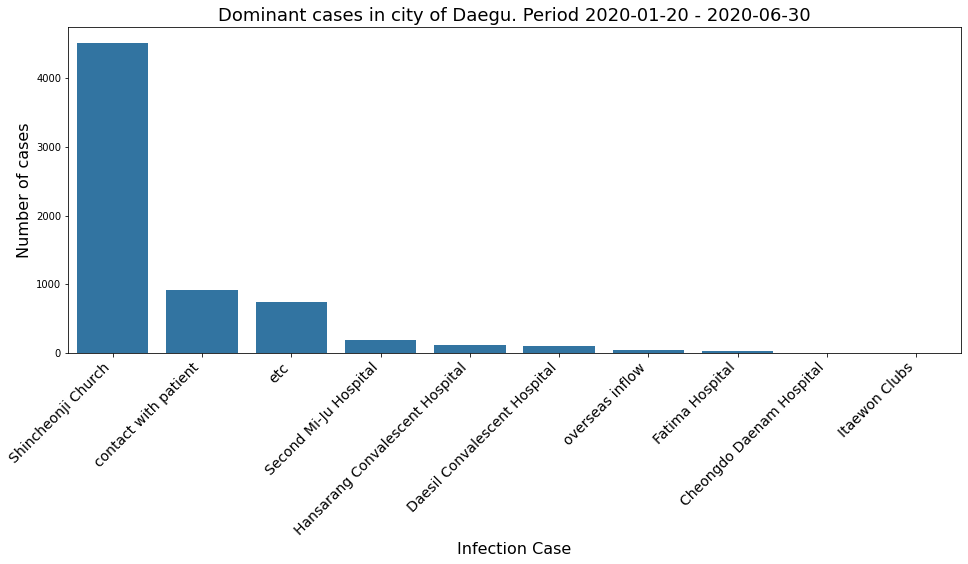

In [27]:
plt.figure(figsize=(16, 6))

daegu_filter = df_Case["province"] == "Daegu"
dominant_cases_daegu = pd.DataFrame(df_Case[daegu_filter].groupby(["infection_case"])["confirmed"].agg('sum'))
dominant_cases_daegu = dominant_cases_daegu.sort_values(by=["confirmed"], ascending=False)
dominant_cases_daegu = dominant_cases_daegu.reset_index()
dominant_cases_daegu

ax = sns.barplot(
    x=dominant_cases_daegu['infection_case'],
    y=dominant_cases_daegu["confirmed"],
    color="#1f77b4")

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',
    fontsize=14)

ax.set_title("Dominant cases in city of Daegu. Period 2020-01-20 - 2020-06-30", fontsize=18)
ax.set_xlabel("Infection Case", fontsize=16)
ax.set_ylabel("Number of cases", fontsize=16)

plt.show()

<div style="text-align: justify">
    The most of the total number of cases are from one place - <b>Shincheonji Church</b>. As a matter of fact, Daegu, in South Korea, was host to the first large coronavirus outbreak outside of China<sup>2</sup>.</div>

2. [Source: World Economy Forum](https://www.weforum.org/agenda/2020/04/south-korean-daegu-china-coronavirus-covid19-cases-virus/)

The spread of infections at a church in Daegu drove a massive spike in cases in South Korea beginning in late February of 2020:

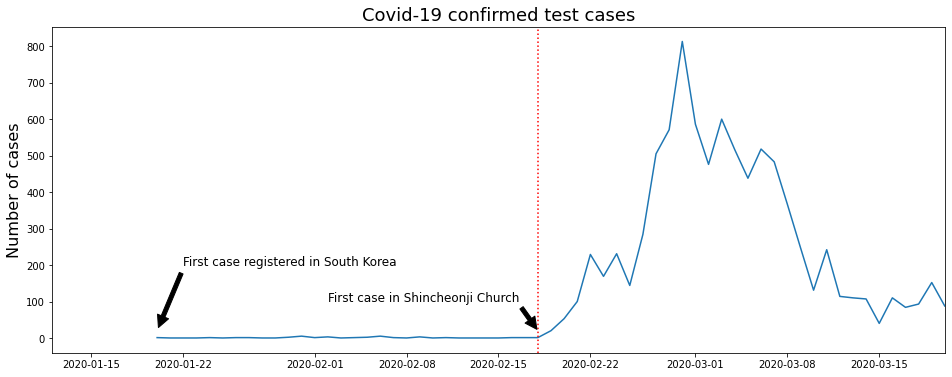

In [28]:
df_Time_merged = df_Time.merge(policy_by_time, left_on=['date'], right_on=['start_date'], how='left')

f, ax = plt.subplots(1, 1, figsize=(16, 6))

sns.lineplot(
    x=df_Time_merged['date'],
    y=df_Time_merged['confirmed_per_day'],
    ax=ax)

ax.set_title("Covid-19 confirmed test cases", fontsize=18)
ax.set_ylabel("Number of cases", fontsize=16)
ax.set_xlabel("")
ax.set_xlim([datetime.date(2020, 1, 12), datetime.date(2020, 3, 20)])

search_church = df_Patient_info['infection_case'] == 'Shincheonji Church'
first_case_church = pd.DataFrame(df_Patient_info[search_church]['confirmed_date'])
first_case_church = first_case_church.sort_values(by=['confirmed_date'])
first_case_in_SK = df_Patient_info.sort_values(by=['confirmed_date'])['confirmed_date'].iloc[0]

x1 = first_case_in_SK
x2 = first_case_church['confirmed_date'].iloc[0]

ax.annotate(
    'First case registered in South Korea',
    xy=(x1, 20),
    xytext=(mdates.date2num(x1)+2, 200),
    fontsize=12,
    arrowprops=dict(facecolor='black', shrink=0.05))

ax.annotate(
    'First case in Shincheonji Church',
    xy=(x2, 20),
    xytext=(mdates.date2num(x2)-16, 100),
    fontsize=12,
    arrowprops=dict(facecolor='black', shrink=0.05))

ax.axvline(x2, color="red", linestyle=":")

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.show()

<div style="text-align: justify">
The main health authority for the COVID-19, the Korea Disease Control and Prevention Agency (<a href="https://www.kdca.go.kr/index.es?sid=a3">KDCA</a>) raised the level of infectious disease alert to <font color='red'>red</font>, which is the highest level, on <b>23 February</b>. In the highest alert level, the government is tasked with blocking the entry of COVID-19 from overseas, taking quarantine measures such as the isolation of patients and contacts, and pushing ahead with strategies to prevent and minimize community spread<sup>3</sup>. Mask distribution was increased as well as strong social distancing campaign was introduced. Rapid increase in new cases continued for a few more days <b>until on the 29 February 2020 when the country reached its peak</b>. The dramatic increase in the number of cases was mainly derived from a large outbreak in Daegu, the fourth biggest city with 2.5 million people<sup>4</sup>, and Gyeongsang Province. However, the rapid increase in new cases had turned downward after the number of new cases peaked at <b>813</b> cases. As the number of new cases has rapidly dropped, the curve of total confirmed cases has flattened.</div>

3. [Source: Briefing on the pan-governmental meeting for COVID-19](https://www.mohw.go.kr/eng/nw/nw0101vw.jsp?PAR_MENU_ID=1007&MENU_ID=100701&page=10&CONT_SEQ=353124)

4. [Source: Daegu population](https://www.google.com/search?q=daegu+population&oq=daegu+po&aqs=edge.1.69i57j0i512l7j69i60.3999j0j1&sourceid=chrome&ie=UTF-8)

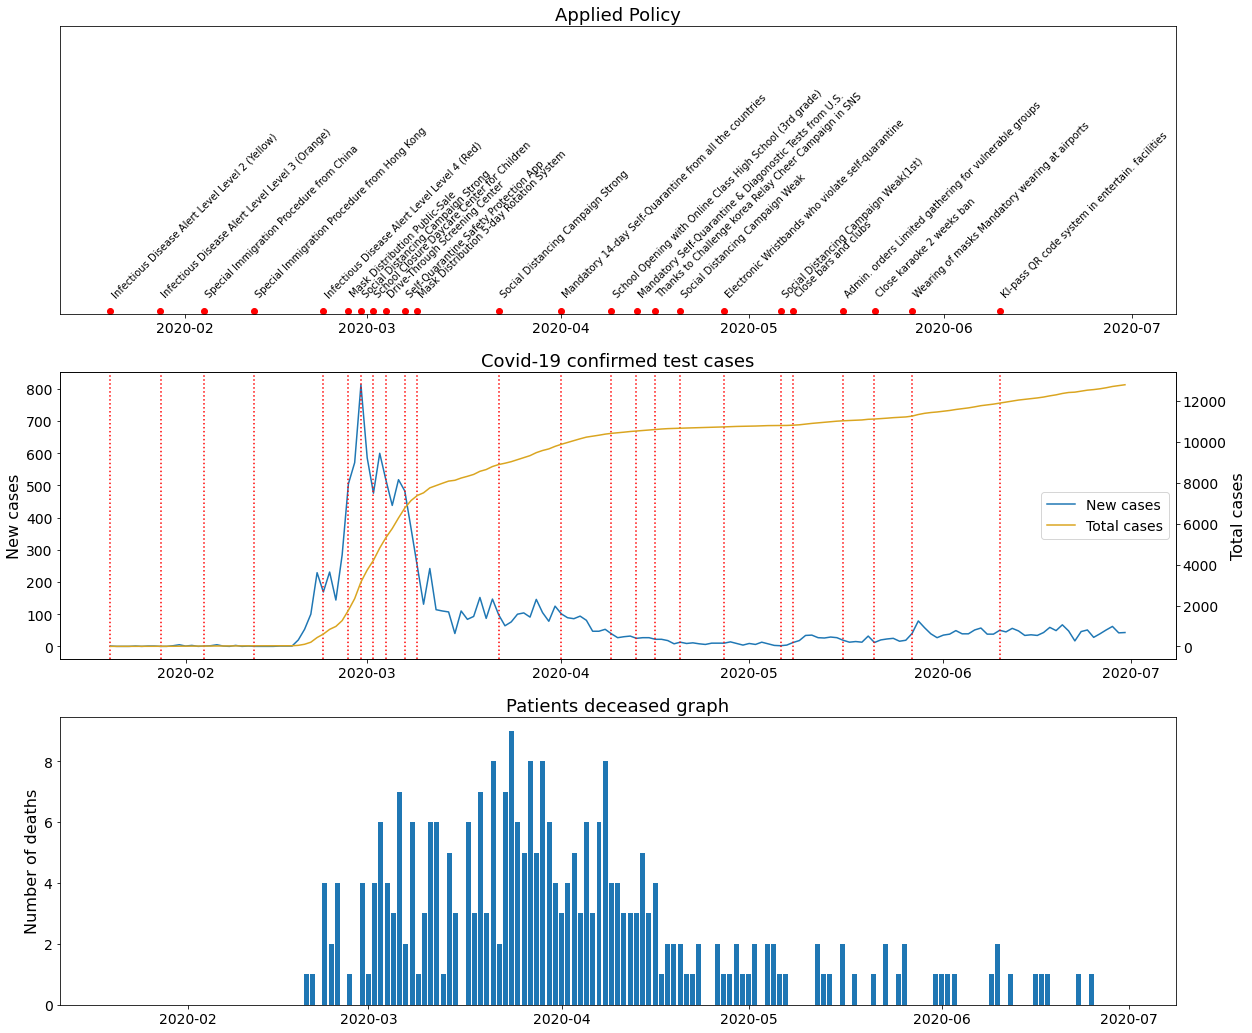

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 18))

ax1.scatter(
    df_Time_merged['date'],
    df_Time_merged["value"],
    color='red')

ax2.plot(
    df_Time_merged['date'],
    df_Time_merged['confirmed_per_day'],
    label="New cases")

ax3.bar(
    df_Time_merged['date'],
    df_Time_merged['deceased_per_day'])

ax4 = ax2.twinx()

ax4.plot(
    df_Time_merged['date'],
    df_Time_merged['confirmed'],
    color='goldenrod',
    label='Total cases')

ax1.set_title("Applied Policy", fontsize=18)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.tick_params(axis='y', colors='white')
ax1.set_ylim([0.999, 1.1])
ax1.set_xlim([datetime.date(2020, 1, 12), datetime.date(2020, 7, 8)])

ax2.set_title("Covid-19 confirmed test cases", fontsize=18)
ax2.set_ylabel("New cases", fontsize=16)
ax2.set_xlabel("")

ax3.set_title("Patients deceased graph", fontsize=18)
ax3.set_ylabel("Number of deaths", fontsize=16)
ax3.set_xlabel("")

ax4.set_ylabel("Total cases", fontsize=16)

for i in range(policy_by_time.shape[0]):
    ax1.text(
        x=policy_by_time['start_date'][i],
        y=policy_by_time["value"][i]+0.005,
        s=policy_by_time["policy"][i],
        fontsize=10,
        rotation=45)
    ax2.axvline(
        policy_by_time['start_date'][i],
        color="red",
        linestyle=":")

lines, labels = ax2.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=5, fontsize=14)

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 12

plt.show()

Let's examine the spread of virus among different age groups of the population.<br><br>
<div style="text-align: justify">
The figure below is age-disaggregated data on reported COVID-19 cases as of 30 June 2020. Young adults aged <b>20–29</b> was the age group with the highest rate of infection, which is <b>26.27%</b> of total infections </div>

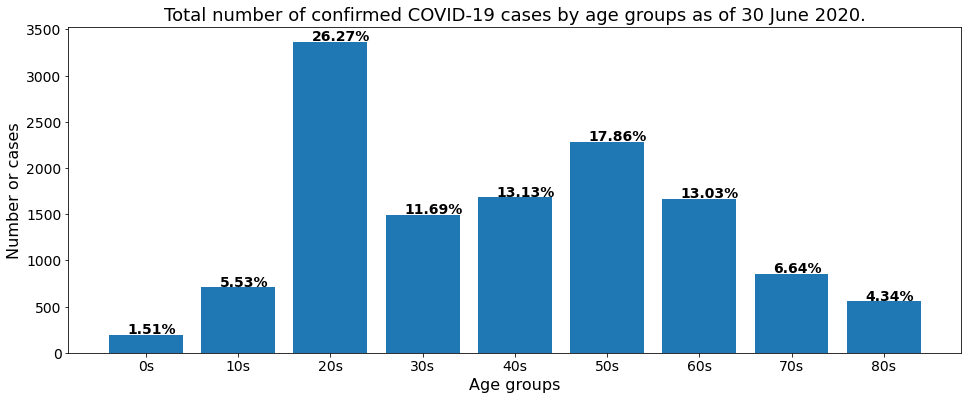

In [30]:
confirmed_by_age = pd.DataFrame(df_TimeAge[-9:].groupby(["age"])["confirmed"].agg("sum"))

percentage = []
total_deceased = confirmed_by_age['confirmed'].sum()

for i in range(confirmed_by_age.shape[0]):
    pct = (confirmed_by_age.confirmed[i] / total_deceased) * 100
    percentage.append(round(pct, 2))
confirmed_by_age['Percentage'] = percentage

plt.figure(figsize=(16, 6))

plot = plt.bar(
    confirmed_by_age.index,
    confirmed_by_age['confirmed'],
    color="#1F77B4")

for j, bar in enumerate(plot):
    width = bar.get_width()
    height = bar.get_height()
    x, y = bar.get_xy()
    plt.text(
        x+width/4,
        y+height+15,
        str(confirmed_by_age.Percentage[j])+'%',
        weight='bold',
        fontsize=14)

plt.title("Total number of confirmed COVID-19 cases by age groups as of 30 June 2020.", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Age groups", fontsize=16)
plt.ylabel("Number or cases", fontsize=16)
plt.show()

<div style="text-align: justify">
Below we can see the spread of COVID-19 infection among different ages and genders. Unfortunately gender & age are known only for 30% of all patients. This data consist only fully analyzed and traced cases and do not include all infections. Nevertheless the trend is visible. </div><br>
<div style="text-align: justify">
In total, the male to female ratio is confirmed approximately 4:6 (M:F)<sup>5</sup> which is very close to our data.
As of June 30, there was a total of <b>12,800</b> confirmed cases in South Korea, of which <b>7,304</b> are women (<b>57.1%</b>). There were <b>282</b> deaths, which included <b>131</b> women (<b>46.5%</b>). Globally, more men are infected than women, and being male is considered a “risk factor” for COVID-19 infection. However, this does not correspond to the outbreak in South Korea. Local epicenters of COVID-19, including a religious community, public rental apartments, a call center, and nursing facilities, are mostly female-dominated spaces that reflect a strong gender division of labor in South Korea<sup>6</sup></div>

5. [Source: National Library of Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7766828/)
6. [Source: SAGE Journals](https://journals.sagepub.com/doi/full/10.1177/1090198120931443)

In [31]:
def calc_pct(a, b):
    return (a / (a + b)) * 100


tot_m_pos = df_TimeGender.iloc[-2]['confirmed']
tot_f_pos = df_TimeGender.iloc[-1]['confirmed']

tot_m_pos_pct = round(calc_pct(tot_m_pos, tot_f_pos), 2)
tot_f_pos_pct = round(calc_pct(tot_f_pos, tot_m_pos), 2)

# tot_m_dec = df_TimeGender.iloc[-2]['deceased']
# tot_f_dec = df_TimeGender.iloc[-1]['deceased']

# tot_m_dec_pct = round(calc_pct(tot_m_dec, tot_f_dec), 2)
# tot_f_dec_pct = round(calc_pct(tot_f_dec, tot_m_dec), 2)

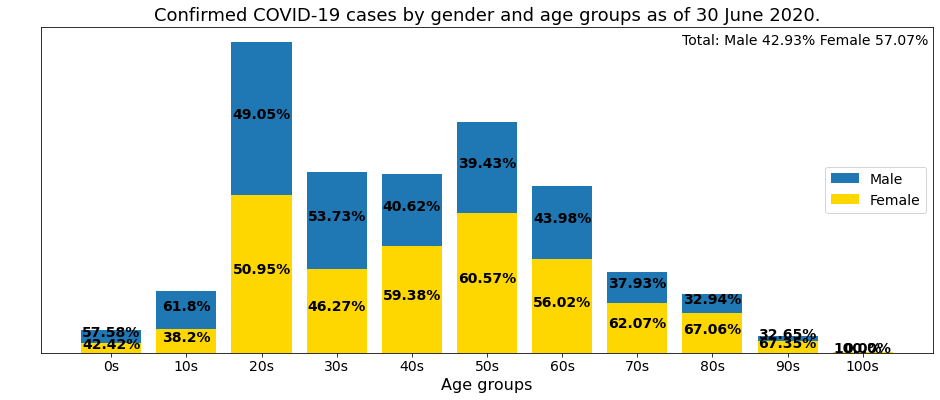

In [32]:
patient_age = pd.DataFrame(df_Patient_info.groupby(['sex'], as_index=True)['age'].value_counts().unstack().fillna(0))
patient_age = patient_age.transpose()
patient_age.sort_index(level='age', key=lambda x: (x.to_series().str[:-1].astype(int)), inplace=True)

fig, ax = plt.subplots(figsize=(16, 6))

plot1 = ax.bar(
    patient_age.index,
    patient_age['male'],
    width=0.8,
    bottom=patient_age['female'],
    label="Male",
    color="#1F77B4")

plot2 = ax.bar(
    patient_age.index,
    patient_age['female'],
    width=0.8,
    label='Female',
    color="gold")

male_pct = [round(calc_pct(m, f), 2) for m, f in zip(plot1.datavalues, plot2.datavalues)]
female_pct = [round(calc_pct(f, m), 2) for m, f in zip(plot1.datavalues, plot2.datavalues)]

for j, bar in enumerate(plot1):
    width = bar.get_width()
    height = bar.get_height()
    x, y = bar.get_xy()
    ax.text(
        x+width/2,
        y+height/2,
        str(male_pct[j])+'%',
        ha='center',
        weight='bold',
        fontsize=14)

for j, bar in enumerate(plot2):
    width = bar.get_width()
    height = bar.get_height()
    x, y = bar.get_xy()
    ax.text(
        x+width/2,
        y+height/2,
        str(female_pct[j])+'%',
        ha='center',
        weight='bold',
        fontsize=14)

ax.text(7.6, 890,
        'Total: Male ' + str(tot_m_pos_pct) + '%' + ' Female ' + str(tot_f_pos_pct) + '%',
        fontsize=14)
plt.title("Confirmed COVID-19 cases by gender and age groups as of 30 June 2020.", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Age groups", fontsize=16)
plt.ylabel("", fontsize=16)
plt.legend(fontsize=14, loc=5)
plt.tick_params(axis='y', colors='white')
plt.show()

<div style="text-align: justify">
Below we look at the people that have been treated. We check how much time they needed to recover by calculating the *delta*  from the time they were diagnosed with the infection (positive coronavirus test) until they were released. It is a right-scewed time delta distribution with most people needed around <b>20</b> days to cure. Other cases are rare, however, it has often happened that only a few days after diagnosis, people could already be considered healthy.</div>

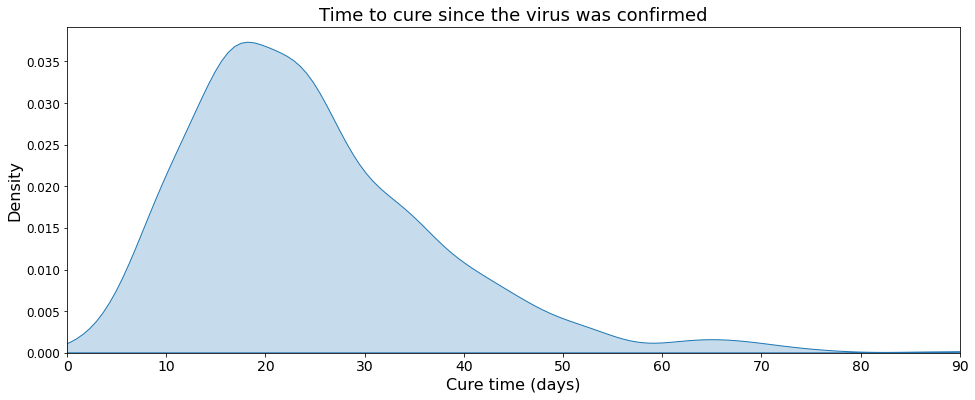

In [33]:
df_Patient_info['delta'] = df_Patient_info['released_date'] - df_Patient_info['confirmed_date']
days_sick_by_age = df_Patient_info["delta"].dt.days

plt.figure(figsize=(16, 6))
ax = sns.kdeplot(
    days_sick_by_age,
    shade=True)
ax.set_title('Time to cure since the virus was confirmed', fontsize=18)
ax.set_xlim([0, 90])
ax.set_ylabel('Density', fontsize=16)
ax.set_xlabel('Cure time (days)', fontsize=16)
plt.show()

<div style="text-align: justify">
Nevertheless, eventhough the most of the positive cases as told earlier are among young or rather young population, - the death rate is reversed. Old people with chronic diseases are more likely to die from COVID-19. Almost <b>93%</b> of all deaths from Covid-19 are among population older than 60.</div>

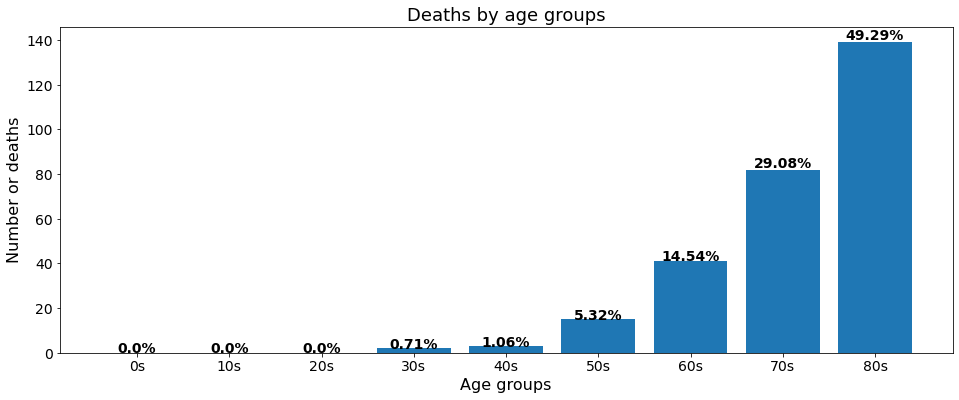

In [34]:
deaths_by_age = pd.DataFrame(df_TimeAge[-9:].groupby(["age"])["deceased"].agg("sum"))
percentage = []
total_deceased = deaths_by_age.deceased.sum()

for i in range(deaths_by_age.shape[0]):
    pct = (deaths_by_age.deceased[i] / total_deceased) * 100
    percentage.append(round(pct, 2))
deaths_by_age['Percentage'] = percentage

plt.figure(figsize=(16, 6))
graph = plt.bar(
    deaths_by_age.index,
    deaths_by_age['deceased'])

for j, bar in enumerate(graph):
    width = bar.get_width()
    height = bar.get_height()
    x, y = bar.get_xy()
    plt.text(
        x+width/2,
        y+height*1.01,
        str(deaths_by_age.Percentage[j])+'%',
        ha='center',
        weight='bold',
        fontsize=14)

plt.title("Deaths by age groups", fontsize=18)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Age groups", fontsize=16)
plt.ylabel("Number or deaths", fontsize=16)
plt.show()

We can see a very strong positive relation of age and death from COVID-19 rate.

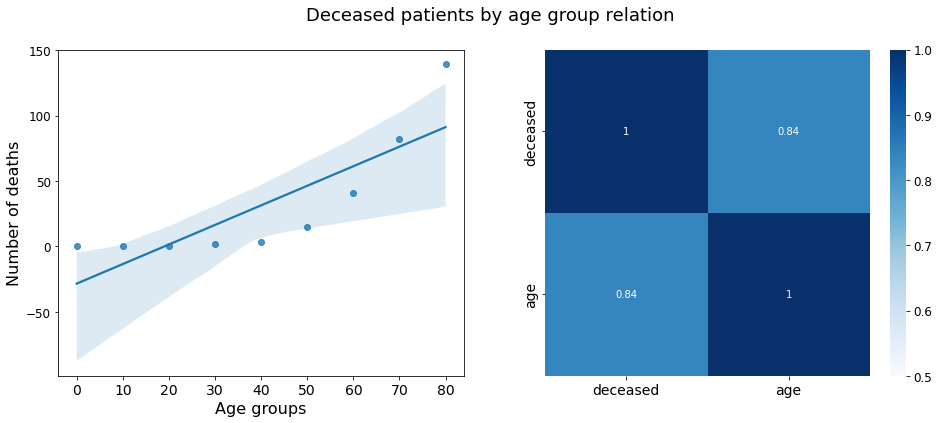

In [35]:
deaths_by_age_corr = pd.DataFrame(df_TimeAge[-9:].groupby(["age"])["deceased"].agg("sum"))
deaths_by_age_corr['age'] = [int(item[:-1]) for item in deaths_by_age_corr.index]
deaths_by_age_corr.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.regplot(
    x='age',
    y='deceased',
    data=deaths_by_age_corr,
    ax=ax[0])

sns.heatmap(
    deaths_by_age_corr.corr(method='pearson'),
    annot=True,
    cmap='Blues',
    ax=ax[1],
    vmin=0.5)

ax[0].set_xlabel("Age groups", fontsize=16)
ax[0].set_ylabel("Number of deaths", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.suptitle('Deceased patients by age group relation', fontsize=18)
plt.show()

<br><br>Now let's see how the virus is mainly spread.

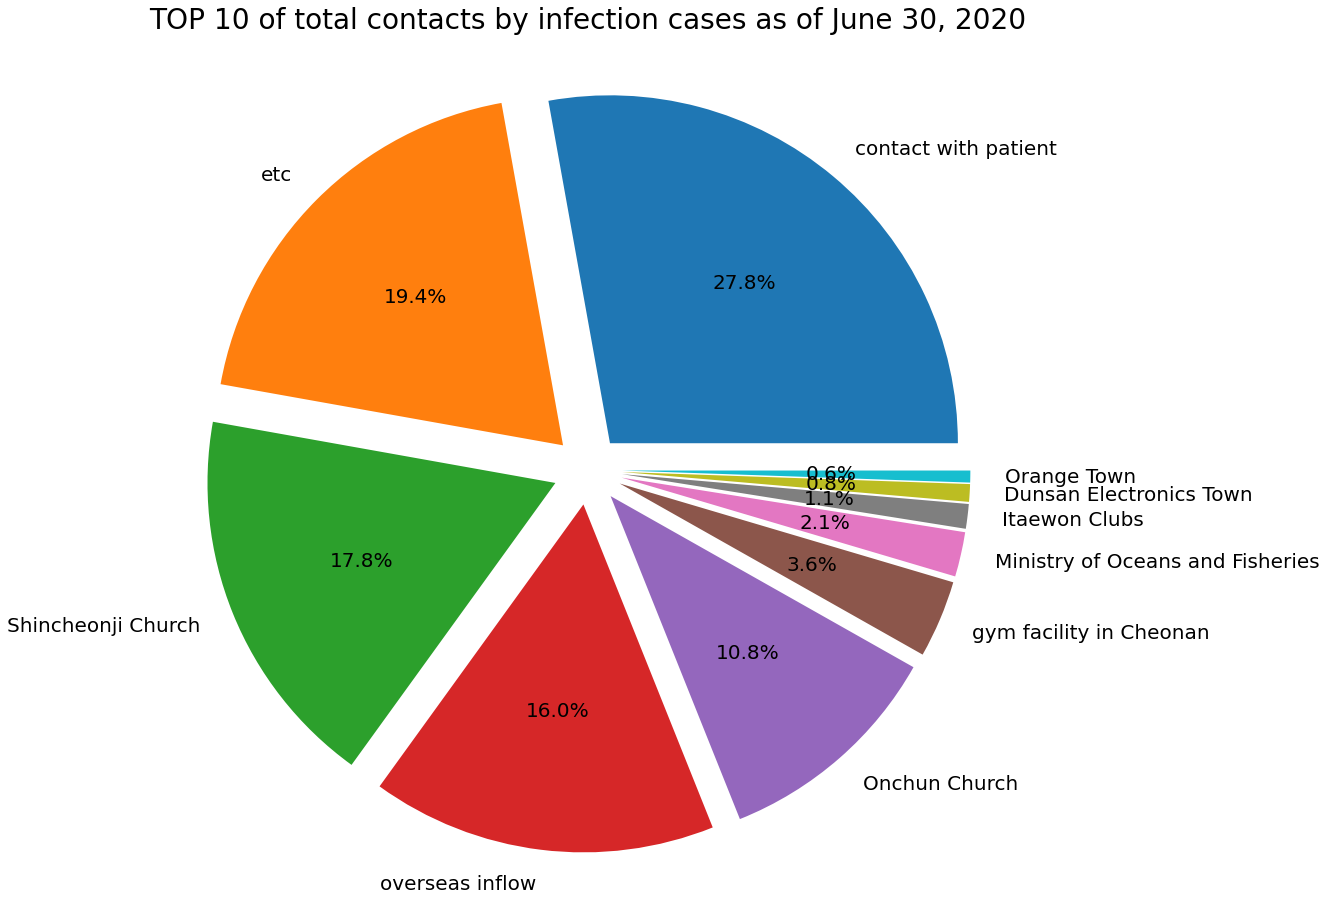

In [36]:
infection_case = df_Patient_info.groupby(['infection_case']).sum().sort_values(
    by=['contact_number'],
    ascending=False).unstack().head(10)

explode = (0.1,) * len(infection_case)
infection_case.plot(
    kind='pie',
    figsize=(20, 16),
    textprops={'fontsize': 20},
    autopct='%1.1f%%',
    explode=explode,
    labels=infection_case.reset_index()['infection_case'])

plt.title("TOP 10 of total contacts by infection cases as of June 30, 2020", fontsize=28)
plt.ylabel("")
plt.show()

The value `overseas inflow` means that the infection is from other country.

The value `etc` includes individual cases, cases where relevance classification is ongoing after investigation, and cases under investigation.

<div style="text-align: justify">
Despite the case of "Shincheonji Church" where it had a big play in overall cases, we see that mainly virus is distributed through contact with another patient and cases from abroad (overseas inflow). The main virus "spreaders" and most contacts had population of age groups 20s to 60s. In other words - the working class.</div>

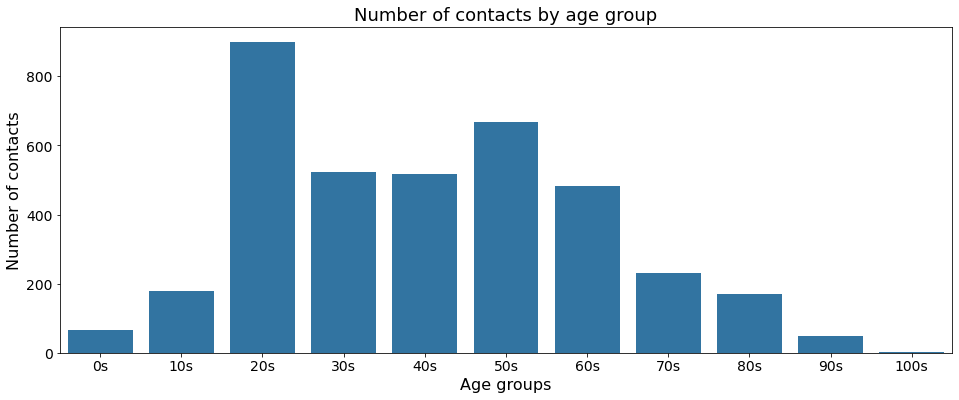

In [37]:
cases_per_age = pd.DataFrame({'cases_count' : df_Patient_info.groupby(["age"])["contact_number"].count()})
cases_per_age.sort_index(
    level='age',
    key=lambda x: (x.to_series().str[:-1].astype(int)),
    inplace=True)

plt.figure(figsize=(16, 6))
sns.barplot(
    x=cases_per_age.index,
    y='cases_count',
    data=cases_per_age,
    color='#1F77B4')

plt.title("Number of contacts by age group", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Age groups", fontsize=16)
plt.ylabel("Number of contacts", fontsize=16)
plt.show()

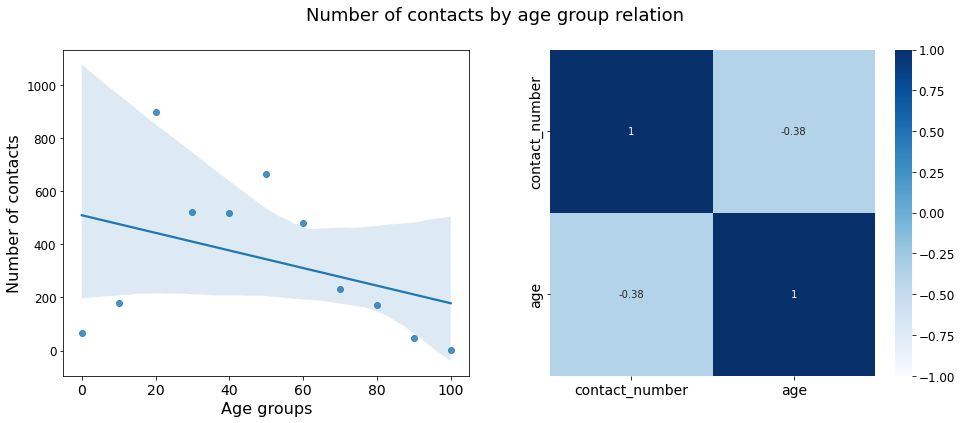

In [38]:
cases_by_age_corr = pd.DataFrame(df_Patient_info.groupby(["age"])["contact_number"].count())
cases_by_age_corr['age'] = [int(item[:-1]) for item in cases_by_age_corr.index]
cases_by_age_corr.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.regplot(
    x='age',
    y='contact_number',
    data=cases_by_age_corr,
    ax=ax[0])

sns.heatmap(
    cases_by_age_corr.corr(method='pearson'),
    annot=True,
    cmap='Blues',
    ax=ax[1],
    vmin=-1)

ax[0].set_xlabel("Age groups", fontsize=16)
ax[0].set_ylabel("Number of contacts", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.suptitle('Number of contacts by age group relation', fontsize=18)
plt.show()

Some patients, which `infection_case` is **contact with patient** has known person which caused the infection. Even though there is a person that caused 51 infection of other persons, more than 50% of them have **infected only one person**. The mean of infection by contact is 2.2 person.

In [39]:
infected_by_per_age = pd.DataFrame({'infected_times' : df_Patient_info["infected_by"].value_counts()})
for i in infected_by_per_age.index:
    try:
        infected_by_per_age.at[i, 'age_group'] = df_Patient_info['age'].loc[int(i)]
        infected_by_per_age.at[i, 'gender'] = df_Patient_info['sex'].loc[int(i)]
    except KeyError:
        infected_by_per_age.at[i, 'age_group'] = None
        infected_by_per_age.at[i, 'gender'] = None
    except ValueError:
        infected_by_per_age.at[i.split(',')[0], 'age_group'] = df_Patient_info['age'].loc[int(i.split(',')[0])]
        infected_by_per_age.at[i.split(',')[0], 'gender'] = df_Patient_info['sex'].loc[int(i.split(',')[0])]

In [40]:
infected_by_per_age['infected_times'].describe()

count    609.000000
mean       2.213465
std        3.442729
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       51.000000
Name: infected_times, dtype: float64

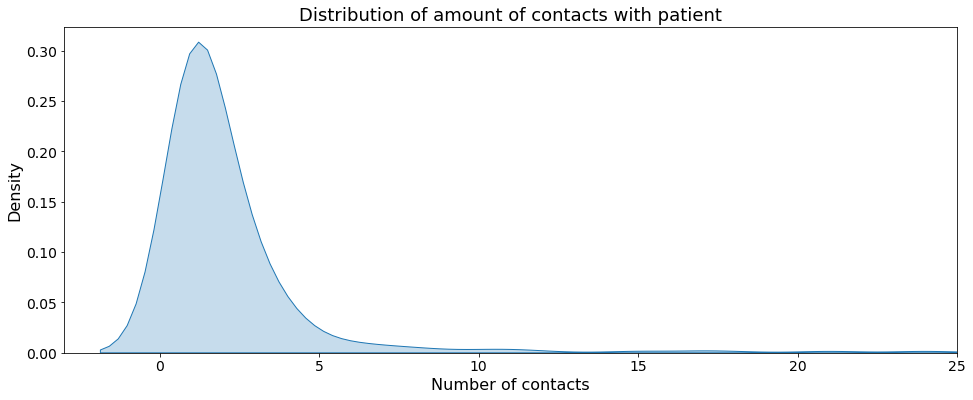

In [41]:
plt.figure(figsize=(16, 6))

sns.kdeplot(infected_by_per_age['infected_times'], shade=True)

plt.title('Distribution of amount of contacts with patient', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of contacts', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.xlim([-3, 25])

plt.show()

<div style="text-align: justify">Let's brake down the number of contacts (not all contacts were confirmed as infected) and number of causes of infection (confirmed cases) by gender. By looking at the graph we could say that more infected woman had more contacts and more times woman caused of infection to the other person, but:</div>

1. Differences are not too large.
2. Results are seriously affected by few large hotspots in churches (where mostly dominates woman, see source No.6)
3. Need more data for conclusions to be drawn for the entire population

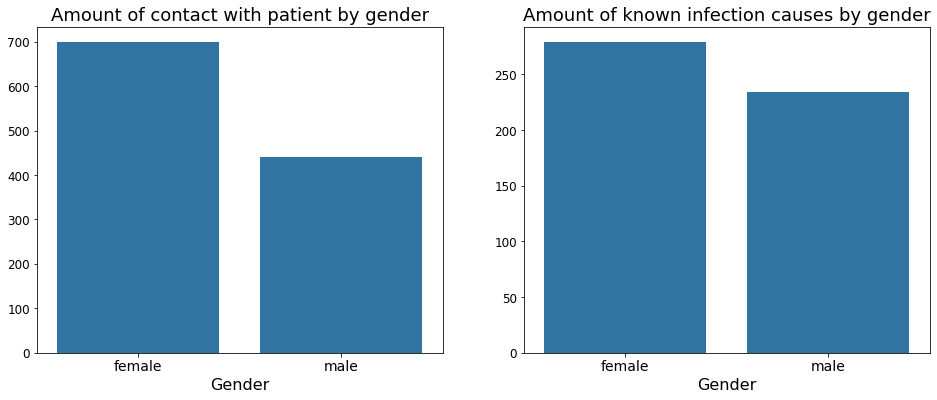

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

gender_data_contacts = pd.DataFrame(infected_by_per_age.groupby(['gender'])['infected_times'].sum()).transpose()
gender_data = pd.DataFrame(infected_by_per_age['gender'].value_counts()).transpose()

sns.barplot(
    data=gender_data_contacts,
    ax=ax[0],
    color='#1F77B4')

sns.barplot(
    data=gender_data,
    ax=ax[1],
    color='#1F77B4')

ax[0].set_title('Amount of contact with patient by gender', fontsize=18)
ax[0].set_xlabel('Gender', fontsize=16)

ax[1].set_title('Amount of known infection causes by gender', fontsize=18)
ax[1].set_xlabel('Gender', fontsize=16)

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.show()

#### CONCLUSIONS <br>

<div style="text-align: justify">Starting from the <b>20'th of January 2020</b>, when the first COVID-19 infection in South Korea was detected and 1 month after, there were only few/None cases per day, until on <b>18'th of February 2020</b> infection was brought to the well-attended church in Daegu city. The number of infections for COVID-19 started to grow exponentially. It took <b>11</b> days and on the <b>29'th of February</b> it peaked out at close to <b>1000</b> infections per day.</div>

* Government of South Korea immedeatly brought many strict policies (expansion of testing, masks distribution, social distancing, closure of schools, isolation of patients etc.) into action and since then the number of new cases has been decreasing day by day. It took **50** days till the number of new cases has dropped to around 10 per day. 

* The most common reason for infection is contact with another already infected person.

* The most frequently infected people are people between **20 and 30** years old and between **50 and 60** (slightly more often women than men).

* Recovery time is usually between **2 and 3.5** weeks.

* Only **24%** of all cases are population older than 60, but even <u>**93%** of all deceased patients is in this group</u>.

* 1 of 4 (**25%**) patients over 80 died.